# VQGAN IMPLEMENTATION

## Helper Function

In [54]:
#!pip3 install albumentations
import argparse
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm import tqdm
import os
#import albumentations
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import functools
from torchvision import utils as vutils

#### GROUPNORM
Applies Group Normalization over a mini-batch of inputs as described in the paper Group Normalization

$$
y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
$$

The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. $\gamma$ and $\beta$ are learnable per-channel affine transform parameter vectors of size num_channels if affine is True. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).

This layer uses statistics computed from input data in both training and evaluation modes.

LINK: [GroupNorm](https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html)


#### SWISH ACTIVATION FUNCTION
$$
{\displaystyle \operatorname {swish} (x):=x\times \operatorname {sigmoid} (\beta x)={\frac {x}{1+e^{-\beta x}}}.}
$$

where $β$ is either constant or a trainable parameter depending on the model. 

For $β = 1$, the function becomes equivalent to the Sigmoid-weighted Linear Unit (SiL) function used in reinforcement learning whereas for $β = 0$, the function turns into the scaled linear function $f(x) = x/2$. With $β → ∞$, the sigmoid component approaches a 0-1 function, so swish becomes like the ReLU function. 

Thus, it can be viewed as a smoothing function which nonlinearly interpolates between a linear function and the ReLU function. This function uses non-monotonicity, and may have influenced the proposal of other activation functions with this property such as Mish and Phish.

LINK: [Swish Function](https://en.wikipedia.org/wiki/Swish_function)


#### Residual Block

Residual connections are the same thing as 'skip connections'. They are used to allow gradients to flow through a network directly, without passing through non-linear activation functions.

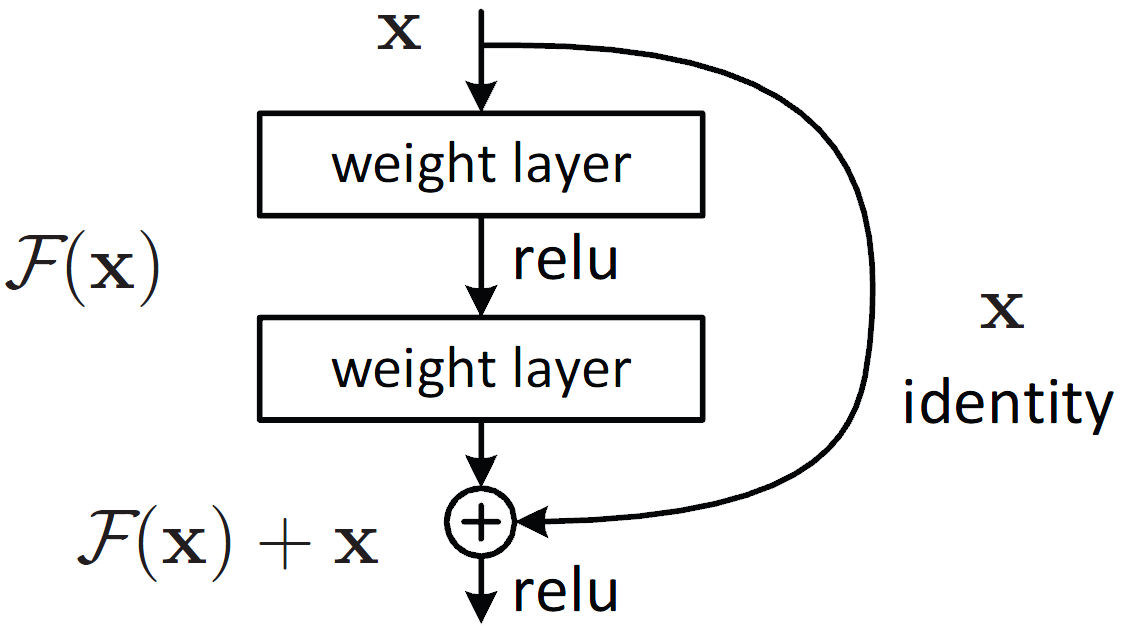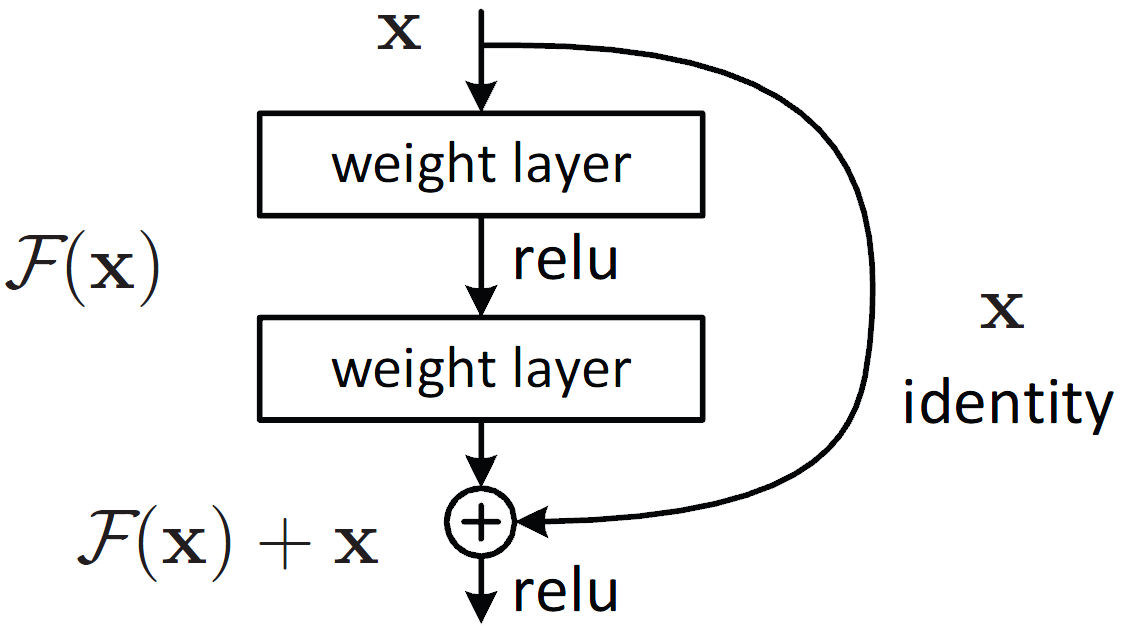

LINK: [Residual Block](https://stats.stackexchange.com/a/321112)

#### UpSample Block

Upsampling blocks contain layers that increase the spatial resolution of images and generate a high-resolution image of dimensions

The Upsample block resamples each channel of the Mi-by-N input at a rate L times higher than the input sample rate by inserting L-1 zeros between consecutive samples. 

You specify the integer L in the Upsample factor parameter. The Sample offset parameter, D, allows you to delay the output samples by an integer number of sample periods. Doing so enables you to select any of the L possible output phases. The value you specify for the Sample offset parameter must be in the range $0≤D<(L−1)$.

LINK: [UpSample Block](https://www.mathworks.com/help/dsp/ref/upsample.html)


#### DownSample Block

The Downsample block decreases the sampling rate of the input by deleting samples. When the block performs frame-based processing, it resamples the data in each column of the Mi-by-N input matrix independently. When the block performs sample-based processing, it treats each element of the input as a separate channel and resamples each channel of the input array across time. The resample rate is K times lower than the input sample rate, where K is the value of the Downsample factor parameter. The Downsample block resamples the input by discarding K–1 consecutive samples following each sample that is output.

#### Non-Local Block

A Non-Local Block is an image block module used in neural networks that wraps a non-local operation. We can define a non-local block as:
$$
\mathbb{z}_{i} = W_{z}\mathbb{y_{i}} + \mathbb{x}_{i}
$$

where  is the output from the non-local operation and 𝕩 is a residual connection.

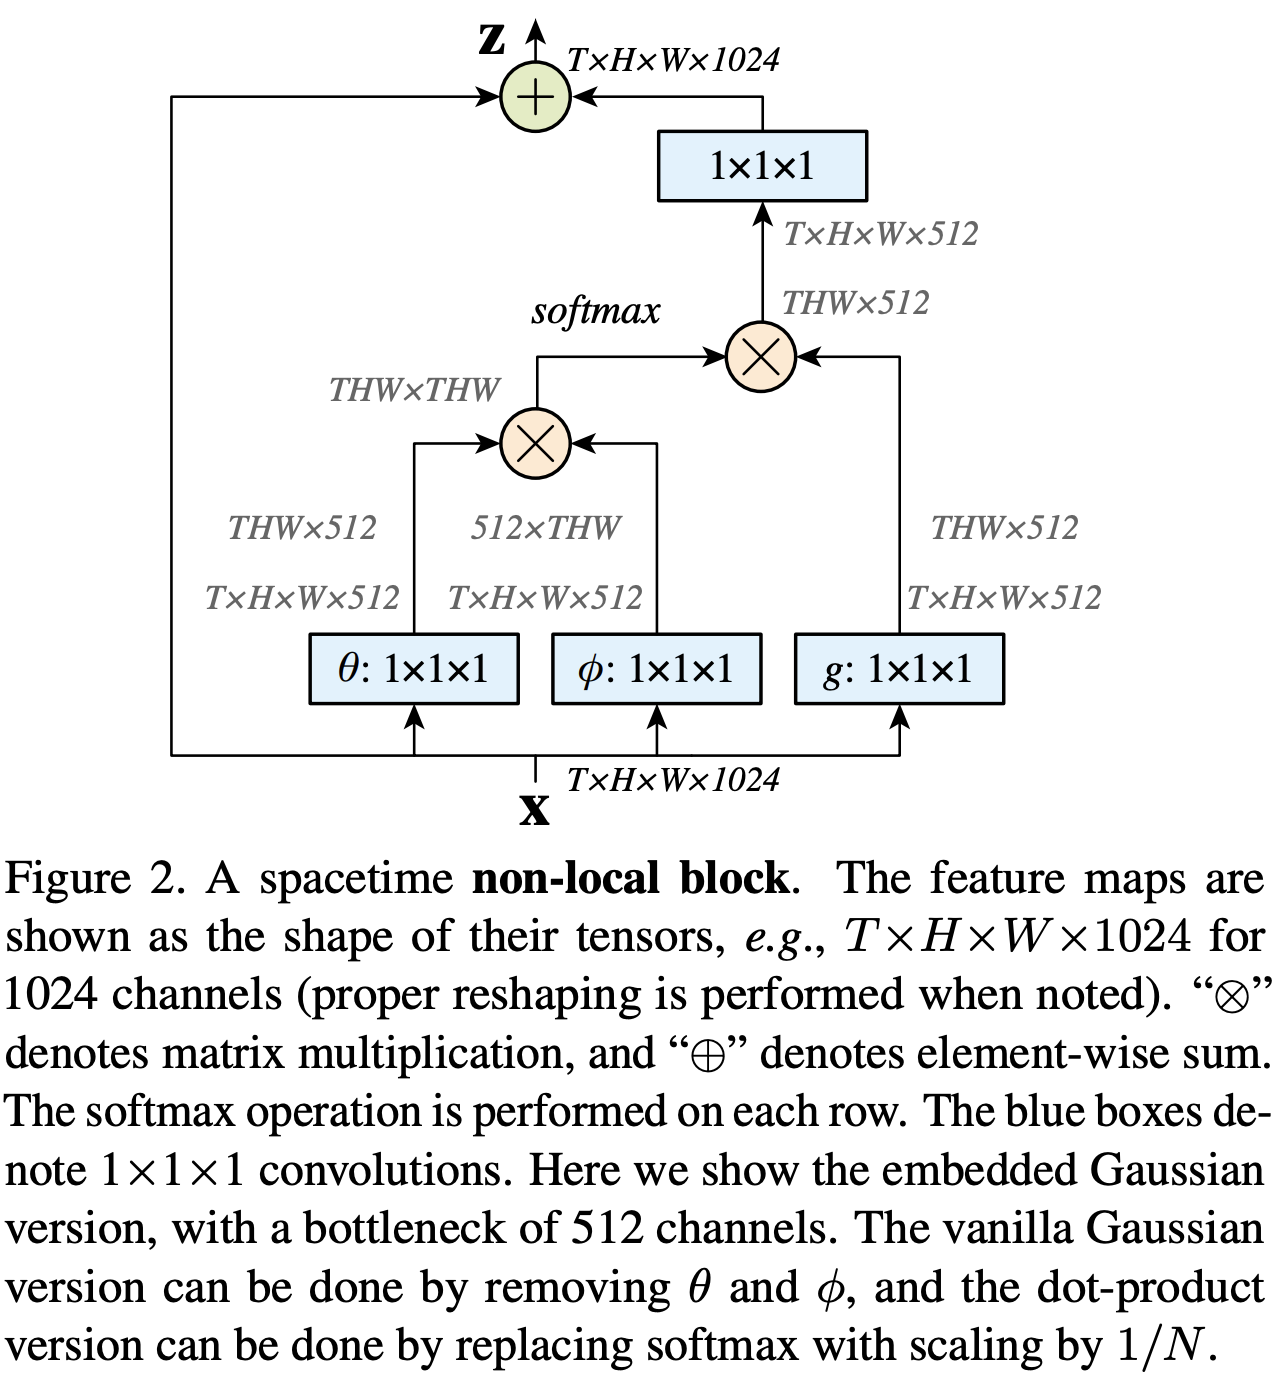

In [38]:
class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

## Encoder

In [50]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Decoder

In [40]:
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Codebook

In [10]:
class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

## VQGAN

In [11]:
class VQGAN(nn.Module):
    def __init__(self, args):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(args).to(device=args.device)
        self.decoder = Decoder(args).to(device=args.device)
        self.codebook = Codebook(args).to(device=args.device)
        self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)
        self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e4).detach()
        return 0.8 * λ

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))

## Descriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Lpips

In [14]:
URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

## UTILS

In [48]:
from torch.utils.data import Dataset, DataLoader

# --------------------------------------------- #
#                  Data Utils
# --------------------------------------------- #

import os, pickle, re, csv
from tqdm import tqdm
import numpy as np
import torch.utils.data
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import PIL
from collections import Counter
import nltk
import json
import functools

image_transforms = transforms.Compose([PIL.Image.fromarray, 
                                           transforms.Resize((64, 64)),
                                           #transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # dataset = TextDataset(cfg.DATA_DIR, 'train',
        #                       imsize=cfg.IMSIZE,
        #                       transform=image_transform)
        #assert dataset
def video_transform(video, image_transform):
    vid = []
    for im in video:
        vid.append(image_transform(im))
    vid = torch.stack(vid).permute(1, 0, 2, 3)
    print("vid value: ", vid)
    return vid

video_len = 5
n_channels = 3
    # functools.partial takes methods/functions as an input
video_transforms = functools.partial(video_transform, image_transform=image_transforms)

class VideoFolderDataset(torch.utils.data.Dataset):
    def __init__(self, folder, counter = None, cache=None, min_len=4, mode='train', load_images=False, id_file='train_seen_unseen_ids.npy'):
        self.lengths = []
        self.followings = []
        dataset = ImageFolder(folder)
        self.dir_path = folder
        self.total_frames = 0
        self.images = []
        self.labels = np.load(os.path.join(folder, 'labels.npy'), allow_pickle=True, encoding='latin1').item()
        if cache is not None and os.path.exists(cache + 'img_cache' + str(min_len) + '.npy') and os.path.exists(cache + 'following_cache' + str(min_len) +  '.npy'):
            self.images = np.load(cache + 'img_cache' + str(min_len) + '.npy', encoding='latin1')
            self.followings = np.load(cache + 'following_cache' + str(min_len) + '.npy')
        else:
            for idx, (im, _) in enumerate(
                    tqdm(dataset, desc="Counting total number of frames")):
                img_path, _ = dataset.imgs[idx]
                v_name = img_path.replace(folder,'')
                id = v_name.split('/')[-1]
                id = int(id.replace('.png', ''))
                v_name = re.sub(r"[0-9]+.png",'', v_name)
                if id > counter[v_name] - min_len:
                    continue
                following_imgs = []
                for i in range(min_len):
                    following_imgs.append(v_name + str(id+i+1) + '.png')
                self.images.append(img_path.replace(folder, ''))
                self.followings.append(following_imgs)
            np.save(os.path.join(folder, 'img_cache' + str(min_len) + '.npy'), self.images)
            np.save(os.path.join(folder, 'following_cache' + str(min_len) + '.npy'), self.followings)

        # train_id, test_id = np.load(self.dir_path + 'train_test_ids.npy', allow_pickle=True, encoding='latin1')
        train_id, val_id, test_id = np.load(os.path.join(self.dir_path, id_file), allow_pickle=True)
        if mode == 'train':
            orders = train_id
        elif mode =='val':
            orders = val_id[:2320]
        elif mode == 'test':
            orders = test_id
        else:
            raise ValueError
        orders = np.array(orders).astype('int32')
        self.images = self.images[orders]
        self.followings = self.followings[orders]
        print("Total number of clips {}".format(len(self.images)))

        self.image_arrays = {}
        if load_images:
            for idx, (im, _) in enumerate(
                    tqdm(dataset, desc="Counting total number of frames")):
                img_path, _ = dataset.imgs[idx]
                self.image_arrays[img_path] = im

    def sample_image(self, im):
        shorter, longer = min(im.size[0], im.size[1]), max(im.size[0], im.size[1])
        video_len = int(longer/shorter)
        se = np.random.randint(0, video_len, 1)[0]
        #print(se*shorter, shorter, (se+1)*shorter)
        return im.crop((0, se * shorter, shorter, (se+1)*shorter)), se

    def __getitem__(self, item):
        lists = [self.images[item]]
        for i in range(len(self.followings[item])):
            lists.append(str(self.followings[item][i]))
        return lists

    def __len__(self):
        return len(self.images)

class StoryDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, textvec, transform, return_caption=False, out_dir=None):
        self.dir_path = dataset.dir_path
        self.dataset = dataset
        self.descriptions = np.load(textvec + 'descriptions_vec.npy', allow_pickle=True, encoding='latin1').item()
        self.attributes = np.load(textvec + 'descriptions_attr.npy', allow_pickle=True, encoding='latin1').item()
        self.subtitles = np.load(textvec + 'subtitles_vec.npy', allow_pickle=True, encoding='latin1').item()
        self.descriptions_original = np.load(textvec + 'descriptions.npy', allow_pickle=True, encoding='latin1').item()
        self.transforms = transform
        self.labels = dataset.labels
        self.return_caption = return_caption
        if self.return_caption:
            print("return_caption: " + self.return_caption)
            self.init_mart_vocab()
            self.max_len = self.tokenize_descriptions()
            print("Max sequence length = %s" % self.max_len)
        else:
            self.vocab = None
        self.out_dir = out_dir

    def tokenize_descriptions(self):
        caption_lengths = []
        self.tokenized_descriptions = {}
        for img_id, descs in self.descriptions_original.items():
            self.tokenized_descriptions[img_id] = [nltk.tokenize.word_tokenize(caption.lower()) for caption in descs]
            caption_lengths.extend([len(c) for c in self.tokenized_descriptions[img_id]])
        return max(caption_lengths) + 2

    def save_story(self, output, save_path = './'):
        all_image = []
        images = output['images_numpy']
        texts = output['text']
        for i in range(images.shape[0]):
            all_image.append(np.squeeze(images[i]))
        output = PIL.Image.fromarray(np.concatenate(all_image, axis = 0))
        output.save(save_path + 'image.png')
        fid = open(save_path + 'text.txt', 'w')
        for i in range(len(texts)):
            fid.write(texts[i] +'\n' )
        fid.close()
        return

    def _sentence_to_idx(self, sentence_tokens):
        """[BOS], [WORD1], [WORD2], ..., [WORDN], [EOS], [PAD], ..., [PAD], len == max_t_len
        All non-PAD values are valid, with a mask value of 1
        """
        max_t_len = self.max_len
        sentence_tokens = sentence_tokens[:max_t_len - 2]

        # pad
        valid_l = len(sentence_tokens)
        mask = [1] * valid_l + [0] * (max_t_len - valid_l)
        sentence_tokens += [self.vocab.pad_word] * (max_t_len - valid_l)
        input_ids = [self.vocab.word2idx.get(t, self.vocab.word2idx[self.vocab.unk_word]) for t in sentence_tokens]

        return input_ids, mask

    def __getitem__(self, item):
        lists = self.dataset[item]
        labels = []
        image = []
        subs = []
        des = []
        attri = []
        text = []
        input_ids = []
        masks= []
        im_sample_idxs = []
        for idx, v in enumerate(lists):
            img_id = str(v).replace('.png','')[2:-1]
            path = self.dir_path + img_id + '.png'
            if self.dataset.image_arrays != {}:
                im = self.dataset.image_arrays[path]
            else:
                if self.out_dir:
                    im = PIL.Image.open(os.path.join(self.out_dir, 'img-%s-%s.png' % (item, idx))).convert('RGB')
                else:
                    im = PIL.Image.open(path)
            if self.out_dir:
                image.append(np.expand_dims(np.array(im), axis = 0))
            else:
                sampled_im, sample_idx = self.dataset.sample_image(im)
                image.append(np.expand_dims(np.array(sampled_im), axis = 0))
                im_sample_idxs.append(sample_idx)
            se = 0
            if len(self.descriptions_original[img_id]) > 1:
                se = np.random.randint(0,len(self.descriptions_original[img_id]),1)
                se = se[0]
            text.append(  self.descriptions_original[img_id][se])
            des.append(np.expand_dims(self.descriptions[img_id][se], axis = 0))
            subs.append(np.expand_dims(self.subtitles[img_id][0], axis = 0))
            labels.append(np.expand_dims(self.labels[img_id], axis = 0))
            attri.append(np.expand_dims(self.attributes[img_id][se].astype('float32'), axis = 0))
            if self.return_caption:
                input_id, mask = self._sentence_to_idx(self.tokenized_descriptions[img_id][se])
                input_ids.append(np.expand_dims(input_id, axis=0))
                masks.append(np.expand_dims(mask, axis=0))

        subs = np.concatenate(subs, axis = 0)
        attri = np.concatenate(attri, axis = 0)
        des = np.concatenate(des, axis = 0)
        labels = np.concatenate(labels, axis = 0)
        image_numpy = np.concatenate(image, axis = 0)
        # image is T x H x W x C
        image = self.transforms(image_numpy)  
        # After transform, image is C x T x H x W
        des = np.concatenate([des, attri], 1)
        ##
        des = torch.tensor(des)
        subs = torch.tensor(subs)
        attri = torch.tensor(attri)
        labels = torch.tensor(labels.astype(np.float32))

        data_item = {'images': image, 'text':text, 'description': des,
                'subtitle': subs, 'images_numpy':image_numpy, 'labels':labels}

        if self.return_caption:
            input_ids = torch.tensor(np.concatenate(input_ids))
            masks = torch.tensor(np.concatenate(masks))
            data_item.update({'input_ids': input_ids, 'masks': masks})

    def __len__(self):
        return len(self.dataset.images)
    
    
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, textvec, transform, return_caption=False):
        self.dir_path = dataset.dir_path
        self.dataset = dataset
        self.transforms = transform
        self.descriptions = np.load(textvec + 'descriptions_vec.npy', allow_pickle=True, encoding='latin1').item()
        self.attributes =  np.load(textvec + 'descriptions_attr.npy', allow_pickle=True, encoding='latin1').item()
        self.subtitles = np.load(textvec + 'subtitles_vec.npy', allow_pickle=True, encoding='latin1').item()
        self.descriptions_original = np.load(textvec + 'descriptions.npy', allow_pickle=True, encoding='latin1').item()
        self.labels = dataset.labels
        self.return_caption = return_caption
        if self.return_caption:
            self.init_mart_vocab()
            self.max_len = self.tokenize_descriptions()
            print("Max sequence length = %s" % self.max_len)
        else:
            self.vocab = None

    def tokenize_descriptions(self):
        caption_lengths = []
        self.tokenized_descriptions = {}
        for img_id, descs in self.descriptions_original.items():
            self.tokenized_descriptions[img_id] = [nltk.tokenize.word_tokenize(caption.lower()) for caption in descs]
            caption_lengths.extend([len(c) for c in self.tokenized_descriptions[img_id]])
        return max(caption_lengths) + 2

    def _sentence_to_idx(self, sentence_tokens):
        """[BOS], [WORD1], [WORD2], ..., [WORDN], [EOS], [PAD], ..., [PAD], len == max_t_len
        All non-PAD values are valid, with a mask value of 1
        """
        max_t_len = self.max_len
        sentence_tokens = sentence_tokens[:max_t_len - 2]

        # pad
        valid_l = len(sentence_tokens)
        mask = [1] * valid_l + [0] * (max_t_len - valid_l)
        sentence_tokens += [self.vocab.pad_word] * (max_t_len - valid_l)
        input_ids = [self.vocab.word2idx.get(t, self.vocab.word2idx[self.vocab.unk_word]) for t in sentence_tokens]

        return input_ids, mask



    def __getitem__(self, item):
        path = self.dir_path + str(self.dataset[item][0])[2:-1]
        id = str(self.dataset[item][0]).replace('.png','')[2:-1]
        img_id = id
        im = PIL.Image.open(path)
        image, sample_idx = self.dataset.sample_image(im)
        image = self.transforms(np.array(image))
        subs = self.subtitles[id][0]
        se = 0
        if len(self.descriptions_original[id]) > 1:
            se = np.random.randint(0,len(self.descriptions_original[id]),1)
            se = se[0]
        des = self.descriptions[id][se]
        attri = self.attributes[id][se].astype('float32')
        text = self.descriptions_original[id][se]
        label = self.labels[id].astype(np.float32)
        input_id = None
        mask = None
        if self.return_caption:
            input_id, mask = self._sentence_to_idx(self.tokenized_descriptions[id][se])
            input_id = np.array(input_id)
            mask = np.array(mask)

        lists = self.dataset[item]
        content = []
        attri_content = []
        attri_label = []
        for v in lists:
            id =str(v).replace('.png','')[2:-1]
            se = 0
            if len(self.descriptions[id]) > 1:
                se = np.random.randint(0,len(self.descriptions[id]),1)
                se = se[0]
            content.append(np.expand_dims(self.descriptions[id][se], axis = 0))
            attri_content.append(np.expand_dims(self.attributes[id][se].astype('float32'), axis = 0))
            attri_label.append(np.expand_dims(self.labels[id].astype('float32'), axis = 0))
        content = np.concatenate(content, axis = 0)
        attri_content = np.concatenate(attri_content, axis = 0)
        attri_label = np.concatenate(attri_label, axis = 0)
        content = np.concatenate([content, attri_content, attri_label], 1)
        des = np.concatenate([des, attri])
        ##
        content = torch.tensor(content)

        data_item = {'images': image, 'text':text, 'description': des,
                'subtitle': subs, 'labels':label, 'content': content}
        
        image_item = image

        if self.return_caption:
            input_id = torch.tensor(input_id)
            mask = torch.tensor(mask)
            data_item.update({'input_id': input_id, 'mask':mask})
        return image_item
        #return data_item

    def __len__(self):
        return len(self.dataset.images)


class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size

        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        self._length = len(self.images)

        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example


def load_data(args):
    dir_path = args.dataset_path
    #dir_path = "./pororo_data/"
    counter = np.load(os.path.join(dir_path, 'frames_counter.npy'), allow_pickle=True).item()
    print("The number of frames: ", len(counter))
    base = VideoFolderDataset(dir_path, counter = counter, cache = dir_path, min_len = 4, mode="train")
    #storydataset = StoryDataset(base, dir_path, video_transforms)
    imagedataset = ImageDataset(base, dir_path, image_transforms)
    #train_data = ImagePaths(args.dataset_path, size=256)
    train_loader = DataLoader(imagedataset, batch_size=args.batch_size, shuffle=False)
    return train_loader

 
# --------------------------------------------- #
#                  Module Utils
#            for Encoder, Decoder etc.
# --------------------------------------------- #

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()

In [25]:
class TrainVQGAN:
    def __init__(self, args):
        self.vqgan = VQGAN(args).to(device=args.device)
        self.discriminator = Discriminator(args).to(device=args.device)
        self.discriminator.apply(weights_init)
        self.perceptual_loss = LPIPS().eval().to(device=args.device)
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)

        self.prepare_training()

        self.train(args)

    def configure_optimizers(self, args):
        lr = args.learning_rate
        opt_vq = torch.optim.Adam(
            list(self.vqgan.encoder.parameters()) +
            list(self.vqgan.decoder.parameters()) +
            list(self.vqgan.codebook.parameters()) +
            list(self.vqgan.quant_conv.parameters()) +
            list(self.vqgan.post_quant_conv.parameters()),
            lr=lr, eps=1e-08, betas=(args.beta1, args.beta2)
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args.beta1, args.beta2))

        return opt_vq, opt_disc

    @staticmethod
    def prepare_training():
        os.makedirs("results", exist_ok=True)
        os.makedirs("checkpoints", exist_ok=True)

    def train(self, args):
        train_dataset = load_data(args)
        steps_per_epoch = len(train_dataset)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.device)
                    decoded_images, _, q_loss = self.vqgan(imgs)

                    disc_real = self.discriminator(imgs)
                    disc_fake = self.discriminator(decoded_images)

                    disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                    perceptual_loss = self.perceptual_loss(imgs, decoded_images)
                    rec_loss = torch.abs(imgs - decoded_images)
                    perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                    perceptual_rec_loss = perceptual_rec_loss.mean()
                    g_loss = -torch.mean(disc_fake)

                    λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                    vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                    d_loss_real = torch.mean(F.relu(1. - disc_real))
                    d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                    gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                    self.opt_vq.zero_grad()
                    vq_loss.backward(retain_graph=True)

                    self.opt_disc.zero_grad()
                    gan_loss.backward()

                    self.opt_vq.step()
                    self.opt_disc.step()

                    if i % 10 == 0:
                        with torch.no_grad():
                            real_fake_images = torch.cat((imgs[:4], decoded_images.add(1).mul(0.5)[:4]))
                            vutils.save_image(real_fake_images, os.path.join("results", f"{epoch}_{i}.jpg"), nrow=4)

                    pbar.set_postfix(
                        VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                        GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                    )
                    pbar.update(0)
                torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))

In [55]:
import argparse
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="VQGAN")
    parser.add_argument('--latent-dim', type=int, default=256, help='Latent dimension n_z (default: 256)')
    parser.add_argument('--image-size', type=int, default=256, help='Image height and width (default: 256)')
    parser.add_argument('--num-codebook-vectors', type=int, default=1024, help='Number of codebook vectors (default: 256)')
    parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar (default: 0.25)')
    parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images (default: 3)')
    parser.add_argument('--dataset-path', type=str, default='/data', help='Path to data (default: /data)')
    parser.add_argument('--device', type=str, default="cuda", help='Which device the training is on')
    parser.add_argument('--batch-size', type=int, default=6, help='Input batch size for training (default: 6)')
    parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train (default: 50)')
    parser.add_argument('--learning-rate', type=float, default=2.25e-05, help='Learning rate (default: 0.0002)')
    parser.add_argument('--beta1', type=float, default=0.5, help='Adam beta param (default: 0.0)')
    parser.add_argument('--beta2', type=float, default=0.9, help='Adam beta param (default: 0.999)')
    parser.add_argument('--disc-start', type=int, default=10000, help='When to start the discriminator (default: 0)')
    parser.add_argument('--disc-factor', type=float, default=1., help='')
    parser.add_argument('--rec-loss-factor', type=float, default=1., help='Weighting factor for reconstruction loss.')
    parser.add_argument('--perceptual-loss-factor', type=float, default=1., help='Weighting factor for perceptual loss.')
    
    args, unknown = parser.parse_known_args()
    #args = parser.parse_args()
    #args.dataset_path = r"C:\Users\dome\datasets\flowers"
    args.dataset_path = r"./pororo_data/"
    train_vqgan = TrainVQGAN(args)

The number of frames:  183
Total number of clips 10191


100%|████████████████████████████████████████████████████| 1699/1699 [12:01<00:00,  2.36it/s, GAN_Loss=0, VQ_Loss=0.465]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
 64%|█████████████████████████████████                   | 1080/1699 [06:34<03:30,  2.94it/s, GAN_Loss=0, VQ_Loss=0.339]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.